![Texto alternativo](https://laserud.co/wp-content/uploads/2020/05/cropped-LOGOLASER-1.jpg "Grupo LASER")
# Clasificación de Imagenes Desde Cero
## ¿Qué es la Clasificación de Imagenes?
La clasificación de imágenes es la tarea donde se utiliza visión por computador y algoritmos de aprendizaje automático para extraer la idea de una imagen. Esta tarea puede ser tan simple como asignar una etiqueta dependiendo del contenido de una imagen o tan compleja como interpretar el contenido de una imagen y devolver una frase legible para un humano.

La clasificación de imágenes y la comprensión de las imágenes son actualmente y continuará siendo el sub campo más popular de visión por computadora. Hoy en día vemos más aplicaciones, por ejemplo, en smartphones, que pueden interpretar y entender el contenido de una imagen. Incluso en las guerras se están viendo aviones no tripulados guiados mediante algoritmos de visión por computador.

La tarea de clasificación de imágenes consiste básicamente en analizar una imagen de entrada y devolver una etiqueta que categoriza la imagen. Las etiquetas siempre están en un conjunto previamente definido.

Nuestro sistema de clasificación podría también asignar múltiples etiquetas mediante probabilidades de pertenencia. Dada una imagen de entrada de HxW píxeles con tres canales rojo, verde y azul, nuestro objetivo es tomar los N pixeles y averiguar cómo clasificar correctamente el contenido de la imagen.

Un computador ve una imagen como una matriz de pixeles. Los computadores no tienen idea del contenido de una imagen, por ejemplo, si es un gato o un perro, para él es indistinto. El objetivo es que un computador pueda entender el contenido de información de la imagen. Para lograr esto, necesitamos aplicar la extracción de características. Este es el proceso de tomar una imagen de entrada, aplicar un algoritmo y obtener un vector de características (un arreglo de números) que cuantifiquen nuestra imagen.

Para completar este proceso, podemos considerar aplicar algoritmos de extracción de características manuales como HOG, LBPs, u otros algoritmos tradicionales. Otro método es aplicar técnicas de aprendizaje profundo para automáticamente aprender un conjunto de características que pueden ser usadas para cuantificar y etiquetar el contenido de una imagen.


### Conjunto de Datos para el Ejemplo
El conjunto de datos que utilizaremos para desarrollar este tutorial es el Fashion MNIST clothing Classification. Este conjunto de datos relativamente sencillo consiste de aproximadamente 60000 imágenes de 28x28 en escala de grises. Tenemos 10 clases de ropa para clasificar:

- 0: Camiseta/top
- 1: Pantalones
- 2: Jersey
- 3: Vestido
- 4: Abrigo
- 5: Sandalia
- 6: Camisa
- 7: Zapatilla de deporte
- 8: Bolso
- 9: Botín

Este problema es más retador que el clásico problema de dígitos de MNIST. Los mejores resultados para este conjunto de datos están entre 90% – 95% con el conjunto de datos de prueba.

Para el desarrollo de nuestro modelo tenemos básicamente cinco etapas, cargar el conjunto de datos, preparar los datos, definición del modelo, entrenamiento del modelo y presentación de resultados.

En la primera celda indicamos todas las librerías que utilizaremos para el desarrollo del proyecto. Básicamente utilizaremos Keras, Numpy y Matplotlib:

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#from sklearn.model_selection import KFold

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D,\
    MaxPooling2D, BatchNormalization
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD

Primero vamos a cargar el conjunto de datos, este es popular y relativamente simple. Así que se puede utilizar como base para aprender y practicar como desarrollar, entrenar, evaluar y usar una red neuronal para clasificación de imágenes. Este conjunto de datos está incluido dentro de la librería Keras.

Como sabemos en cada imagen solo aparece una prenda de vestir, todas las imágenes están en escala de grises y tienen el mismo tamaño de 28x28 pixeles. Entonces vamos a establecer que los datos de entrada tienen un solo canal de color.

Los valores de cada pixel en la imagen son enteros sin signo entre 0 – 255. Como habíamos mencionado antes tenemos un solo canal, por lo cual la imagen varía entre el blanco y el negro. Vamos a normalizar los valores de los pixeles de la imagen entre [0,1]. Estos datos se almacenarán como flotantes, el procedimiento consiste simplemente en dividir el arreglo de pixeles entre el máximo (255).

In [2]:
BS = 32
EPOCHS = 5

#load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

#reshape
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

#normalize
trainX = np.array(trainX, dtype="float32") / 255.0
testX = np.array(testX, dtype="float32") / 255.0


Este es un problema de clasificación multiobjetivo, donde tenemos 10 clases de objetos. Como se ha mencionado estos datos vienen codificados como entero, sin embargo, para el entrenamiento de redes neuronales se debe utilizar la salida codificada en binario. Este es el conocido codificador “one-hot”, vamos a implementarlo con la clase to_categorical de keras.

In [3]:
#one hot encoder
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [4]:
#probamos aumentar los datos
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

Ahora necesitamos definir un modelo de red neuronal. En este caso vamos a utilizar las siguientes capas: convolucionales, normalización de batch, max pooling, aplanado (flatten), totalmente conectada (Dense), dropout.

Para las capas convolucionales podemos empezar con una capa simple o con capas apiladas. En este caso utilizaremos varias capas convolucionales con un número de filtros entre [8,32]. El tamaño del kernel será fijo de (3x3), utilizaremos el relleno adecuado (same) y en todos los casos la función de activación será de tipo ReLU. Posterior a las capas convolucionales podemos usar una capa de normalización de batch y adicionalmente capas de pooling (agrupación) de (2x2) tomando el máximo argumento.

Dado que estamos trabajando con un problema de clasificación multiobjetivo, debemos establecer la salida adecuada, en este caso utilizaremos una capa Softmax. Esta capa de salida totalmente conectada nos entrega la probabilidad de que un ejemplo pertenezca a cada una de las clases.

Para poder conectar las capas convolucionales con la capa de salida, se deben adecuar las señales. Para esto primero utilizamos una capa de aplanado, la cual nos permite tener un arreglo en forma de vector con base en las salidas bidimensionales de las capas convolucionales. Posteriormente utilizamos una capa totalmente conectada que nos ayudará a extraer ciertas características. Adicionalmente utilizaremos una capa de dropout entre la capa totalmente conectada y la capa de salida. La capa de dropout elimina sinapsis de forma aleatoria con cierta probabilidad, con el objetivo de limitar el sobre ajuste a los datos.

In [5]:
model = Sequential()
inputShape = trainX.shape[1:4]
chanDim = -1
model.add(Conv2D(8, (3, 3), padding='same', activation='relu',
                 kernel_initializer='he_uniform', input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu',
                 kernel_initializer='he_uniform'))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu',
                 kernel_initializer='he_uniform'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1], activation='softmax'))

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        6

Una vez hemos definido el modelo, que en este caso es secuencial, definimos el optimizador que deseamos utilizar para el entrenamiento. Compilamos el modelo, en este caso utilizamos la función de perdida de entropía cruzada categórica dada la naturaleza de clasificación multiclase del problema. Queremos utilizar la métrica de “accuracy” para validar nuestro modelo.

In [6]:
opt = SGD(lr=0.01, momentum=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

El siguiente paso es entrenar el modelo, definimos los datos de entrenamiento y validación, el número de épocas de entrenamiento, ponemos la bandera de “verbose” en true para tener idea de cómo va el entrenamiento del modelo.

In [7]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
1875/1875 [==============================] - 82s 43ms/step - loss: 1.0812 - accuracy: 0.5882 - val_loss: 0.6581 - val_accuracy: 0.7220
Epoch 2/2
1875/1875 [==============================] - 90s 48ms/step - loss: 0.8057 - accuracy: 0.6937 - val_loss: 0.5639 - val_accuracy: 0.7785


Con el objetivo de visualizar los datos del proceso de entrenamiento, graficamos los datos correspondientes al “accuracy” y “loss” tanto para los datos de entrenamiento, como para los datos de prueba. De esta manera podemos verificar si en algún momento el modelo tiene sobreajuste a los datos, además de verificar el rendimiento general del planteamiento.

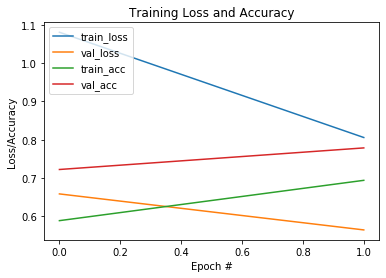

In [8]:
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

Si estamos conformes con el rendimiento de nuestro modelo podemos guardarlo para su posterior uso. En este caso debemos utilizar la extensión h5. Debemos tener instalada en nuestro PC la librería h5py para poder guardar y cargar los modelos de Keras.

In [9]:
model.save("FinalModel.tf",save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: FinalModel.tf\assets


Si queremos utilizar el modelo previamente entrenado, utilizamos el método load_model. Vamos a hacer una demostración del funcionamiento del modelo cargado, con la evaluación del conjunto de datos de test.

In [12]:
from tensorflow.keras.models import load_model

model = load_model('FinalModel.tf')
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 77.850


Debemos tener claro que para clasificar una imagen cualquiera debemos aplicar el mismo preporcesamiento que aplicamos a nuestros conjuntos de entrenamiento y pruebas. Es decir, debemos cargar la imagen, que debe estar en blanco y negro, el tamaño debe ser de 28x28, se debe normalizar el valor de los pixeles entre [0,1].

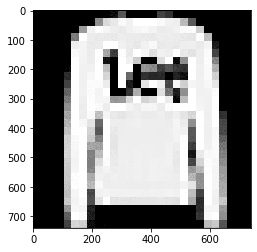

In [4]:
import requests
from io import BytesIO

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import image as mpimg

url = "https://raw.githubusercontent.com/LASER-UD/machinelearning/main/Imagenes/ImageClass/sample_image.png"
response = requests.get(url)
image = mpimg.imread(BytesIO(response.content))
plt.imshow(image)
plt.imsave('prueba.png', image)

In [36]:
img = load_img('prueba.png', color_mode="grayscale", target_size=(28, 28))
# convertimos el objeto a arreglo
img = img_to_array(img)
# redimensionamos a 1 canal
img = img.reshape(1, 28, 28, 1)
# normalizamos
img = np.array(img, dtype="float32") / 255.0

#realizamos la prediccion
result = model.predict(img)[0]
print(result)

[2.7737755e-05 2.1773774e-07 8.0332166e-01 3.7108846e-06 1.2653260e-01
 2.5177464e-08 6.9930807e-02 2.8503122e-10 1.8316595e-04 1.7812805e-09]


In [37]:
print('> Clase: %d ; Probabilidad = %.3f ' % (np.argmax(result), result[np.argmax(result)]*100))

> Clase: 2 ; Probabilidad = 80.332 


## Conclusiones
En este tutorial aprendimos como entrenar desde cero nuestra propia red neuronal convolucional para la clasificación de imágenes. Usamos un conjunto de datos sencillo, sin embargo, el procedimiento de definición de la red, entrenamiento, pruebas, almacenamiento se puede aplicar para problemas de clasificación más complejos.

Al momento de entrenar nuestras redes neuronales debemos ser cuidadosos con el sobreajuste a los datos de entrenamiento. Recordemos que un modelo sobreajustado no tendrá capacidad de generalización y tendrá más un comportamiento de memoria que dificultará que ante nuevos datos el rendimiento sea bueno. En nuestro caso implementamos básicamente dos estrategias para limitar el sobreajuste, la primera es utilizar un generador de imágenes, el cual realiza cambios sobre las imágenes originales, como rotaciones, zoom, etc. La segunda es eliminar conexiones sinápticas entre neuronas de manera aleatoria. Aplicando estas estrategias, primero tenemos un conjunto de imágenes más grande para nuestro entrenamiento, claramente este es un beneficio, pues los modelos de aprendizaje automático necesitan grandes volúmenes de datos para ser entrenados y más aún obtengan buenos resultados.